In [1]:
import sys
import math
import pickle
import numpy as np
import copy
from collections import Counter
import matplotlib.pyplot as plt
from prettytable import PrettyTable
# from sklearn.externals import joblib
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import PCA
sys.path.append('C:\Python36\Lib\site-packages')
import warnings
warnings.filterwarnings("ignore")

In [2]:
mapping = pickle.load(open('./mapping', 'rb'))
train_dict, test_dict = pickle.load(open('./train_and_test_dict', 'rb'))

<h3> Similarity matrix generating function</h3>

In [3]:
def get_sim_matr(tf_idf_vecs):
    sim_matr = cosine_similarity(tf_idf_vecs, tf_idf_vecs)
    min_val = np.min(sim_matr)
    if min_val < 0:
        max_val = np.max(sim_matr)
        sim_matr = (sim_matr - min_val)/(max_val - min_val)
    smoothing_val  = np.unique(sim_matr)[1]
    sim_matr += smoothing_val
    sim_matr = sim_matr / np.max(sim_matr, axis=1)
    return sim_matr

<h3>For F2 feature combinations : overview (without pca)</h3>

In [ ]:
f2_tf_idf_vecs = pickle.load(open('./f2_tf_idf_vecs', 'rb'))

In [4]:
f2_sim_mat = get_sim_matr(f2_tf_idf_vecs)

In [5]:
f2_dim = f2_tf_idf_vecs.shape[1]

In [6]:
np.min(f2_sim_mat)

0.00022564142013179733

<h3> Train and Test functions </h3>

In [7]:
def user_pred_errors(user_ratings, ratio, sim_matr_1, sim_matr_2, mapping):
    movie_ids = list(user_ratings.keys())
    np.random.shuffle(movie_ids)
    train_pts = len(movie_ids) - int(0.2 * len(movie_ids))
    
    train_ratings = np.array([user_ratings[mid] for mid in movie_ids[:train_pts]])
    train_ind = [mapping.index(mid) for mid in movie_ids[:train_pts]]
    
    test_ratings = np.array([user_ratings[mid] for mid in movie_ids[train_pts:]])
    test_ind = [mapping.index(mid) for mid in movie_ids[train_pts:]]
    
    user_mean = np.mean(train_ratings)
    errors = []
    for i in range(len(test_ratings)):
        pred = 0
        sim_sum = 0
        for j in range(len(train_ratings)):
            sim_val = ((sim_matr_1[test_ind[i]][train_ind[j]] * ratio) + (sim_matr_2[test_ind[i]][train_ind[j]] * (1-ratio)))
            pred += sim_val * (train_ratings[j] - user_mean)
            sim_sum += sim_val
        pred = pred / sim_sum
        pred = pred + user_mean
        error = (pred - test_ratings[i])**2
        if error > 25:
            print(error, ratio, pred, test_ratings[i])
        errors.append(error)
    return errors

In [8]:
def training(train_user_dict, sim_matr_1, sim_matr_2, mapping, start, incr): 
    a = []
    rmse = []
    print("Tested for alpha: ", end='')
    for alpha in np.arange(start, 1.01, incr):
        alpha = round(alpha,2)
        error = []
        for j in train_user_dict.keys():
            error += user_pred_errors(train_user_dict[j], alpha, sim_matr_1, sim_matr_2, mapping)
        error = np.array(error)
        mean_all = np.mean(error)
        sv = mean_all ** 0.5
        rmse.append(sv)
        a.append(alpha)
        print(alpha, end=' ')
    print()
    return a, rmse

In [9]:
def testing(test_user_dict, sim_matr_1, sim_matr_2, mapping, alpha): 
    error = []
    for j in test_user_dict.keys():
        error += user_pred_errors(test_user_dict[j], alpha, sim_matr_1, sim_matr_2, mapping)
    error = np.array(error)
    mean_all = np.mean(error)
    rmse = mean_all ** 0.5
    return rmse

In [10]:
def f1_train_test(f1_sim_matr, f2_sim_matr, mapping, train_dict, test_dict):
    alphas, rmse_list = training(train_dict, f1_sim_matr, f2_sim_matr, mapping, 0, 0.05)
    
    get_plot(alphas, rmse_list, axis_names=['Alpha (ratio)','RMSE'], title = 'RMSE plot for different parameter(alpha) values')
    min_ind = rmse_list.index(min(rmse_list))
    best_alpha = alphas[min_ind]
    train_rmse = round(rmse_list[min_ind], 4)
    
    test_rmse = round(testing(test_dict, f1_sim_matr, f2_sim_matr, mapping, best_alpha), 4)    
    print("Results:-  Alpha: ", best_alpha,"   Train RMSE: ", train_rmse, "   Test RMSE: ", test_rmse)
    return test_rmse, train_rmse, best_alpha

##### PCA functions, table and plot functions

In [11]:
# f1_13_tf_idf_vecs_copy = copy.deepcopy(f1_13_tf_idf_vecs)

In [11]:
def get_pca(tf_idf_vecs):
    pca_var = PCA(n_components=0.99).fit(tf_idf_vecs)
    evecs_all = pca_var.components_
    variance_ratios = pca_var.explained_variance_ratio_
    return evecs_all, variance_ratios

In [19]:
def get_test_data_pca(eig_energy_all, evecs_all, f1_13_vecs, f2_sim_mat, mapping, train_dict, test_dict, comb):
    eig_energy = np.arange(0.50, 1.0, 0.05)
    eig_energy = np.append(eig_energy, [0.99])
    best_test_rmse = math.inf
    train_rmse_list, test_rmse_list, alpha_list, dim_list = [], [], [], []
    
    for lambda_val in eig_energy:
        count = 0
        lambda_val_first = eig_energy_all[0]
        while lambda_val_first < lambda_val:
            count += 1
            lambda_val_first += eig_energy_all[count]
        lambda_val_first -= eig_energy_all[count]
        eig_vecs = evecs_all[:count]
        pca_transformed = np.matmul(f1_13_vecs, eig_vecs.T)
        pca_trans_sim_mat = get_sim_matr(pca_transformed)
#         print('sim_min', np.min(pca_trans_sim_mat), 'sim_max', np.max(pca_trans_sim_mat))
        print("Eigen energy: %8.5f" %(lambda_val_first))
        test_rmse, train_rmse, alpha = f1_train_test(pca_trans_sim_mat, f2_sim_mat, mapping, train_dict, test_dict)
        
        if test_rmse < best_test_rmse:
            best_test_rmse = test_rmse
            best_pca_transformed = copy.deepcopy(pca_transformed)
        
        train_rmse_list.append(train_rmse)
        test_rmse_list.append(test_rmse)
        alpha_list.append(alpha)
        dim_list.append(pca_transformed.shape[1])
        
        print("---------------------------------------------------------------------")
    
    with open("Vec_space_after_pca\\f1_phase2_comb_"+str(comb), 'wb') as bpt:
        pickle.dump(best_pca_transformed, bpt)
    
    return train_rmse_list, test_rmse_list, alpha_list, dim_list, eig_energy

In [52]:
def get_plot(x, y, axis_names=['x-axis','y-axis'], title = '', dim_list = []):
    plt.figure(figsize=(12,5))
    plt.plot(x, y) 
    plt.xlabel(axis_names[0])
    plt.ylabel(axis_names[1])
    plt.xticks(x)
    plt.title(title,fontweight='bold')
    if dim_list:
        for i, txt in enumerate(dim_list):
            plt.annotate(txt, (x[i], y[i]))
    plt.grid()
    plt.show()

In [14]:
def get_table_per_feature_comb(var_ratio_list, f1_dim_list, f2_dim, alpha_list, train_rmse_list, test_rmse_list):
    x = PrettyTable()
    x.field_names = ["Index", "Variance ratio", "F1 dim", "F2 dim", "alpha", "Train RMSE", "Test RMSE"]
    for i in range(len(var_ratio_list)):
        x.add_row([str(i+1), round(var_ratio_list[i], 2), f1_dim_list[i], f2_dim, alpha_list[i], train_rmse_list[i], test_rmse_list[i]])
    print(x)

<h3> For F1 feature combination: countries</h3>

In [20]:
comb = 5

In [21]:
f_tf_idf_vecs = pickle.load(open('Vec_space_without_pca\\f1_5_tf_idf_vecs', 'rb'))

In [22]:
evecs_all, variance_ratios = get_pca(f_tf_idf_vecs)

Eigen energy:  0.48124
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


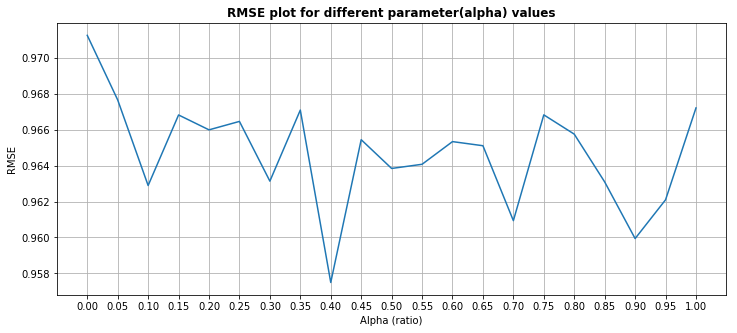

Results:-  Alpha:  0.4    Train RMSE:  0.9575    Test RMSE:  0.9472
---------------------------------------------------------------------
Eigen energy:  0.48124
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


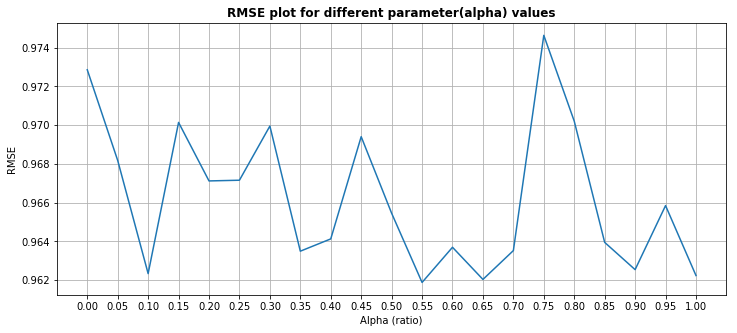

Results:-  Alpha:  0.55    Train RMSE:  0.9619    Test RMSE:  0.9482
---------------------------------------------------------------------
Eigen energy:  0.56890
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


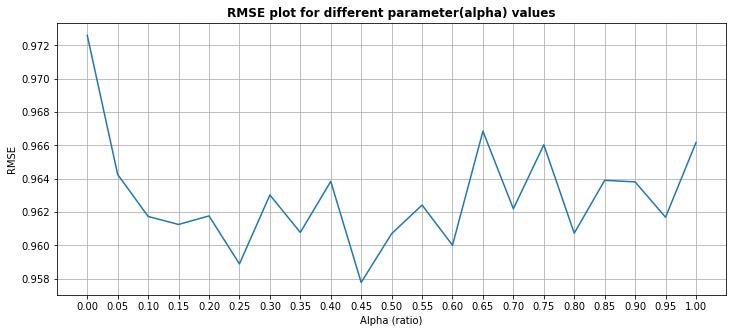

Results:-  Alpha:  0.45    Train RMSE:  0.9578    Test RMSE:  0.9387
---------------------------------------------------------------------
Eigen energy:  0.63449
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


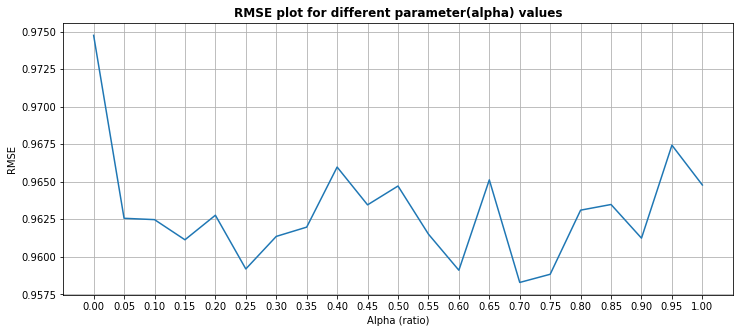

Results:-  Alpha:  0.7    Train RMSE:  0.9583    Test RMSE:  0.9405
---------------------------------------------------------------------
Eigen energy:  0.68339
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


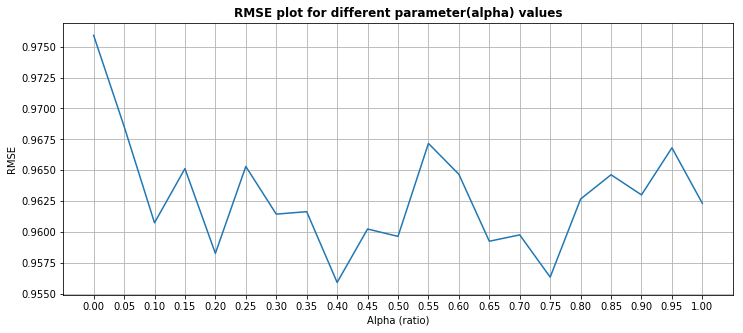

Results:-  Alpha:  0.4    Train RMSE:  0.9559    Test RMSE:  0.9241
---------------------------------------------------------------------
Eigen energy:  0.72087
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


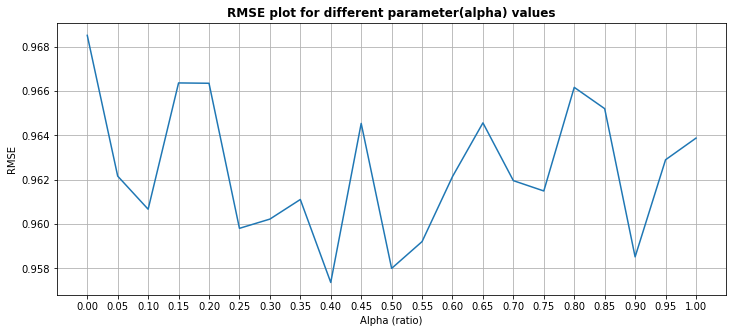

Results:-  Alpha:  0.4    Train RMSE:  0.9574    Test RMSE:  0.9365
---------------------------------------------------------------------
Eigen energy:  0.79027
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


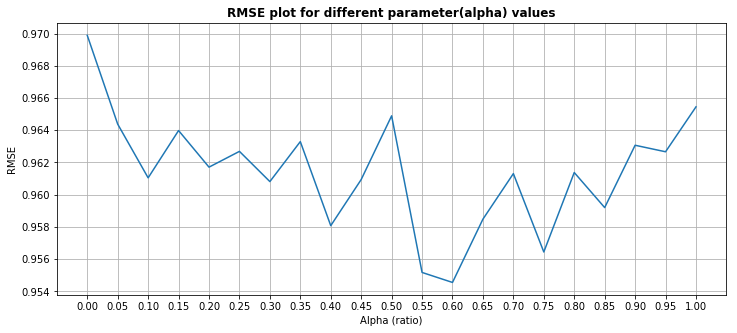

Results:-  Alpha:  0.6    Train RMSE:  0.9546    Test RMSE:  0.9322
---------------------------------------------------------------------
Eigen energy:  0.84368
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


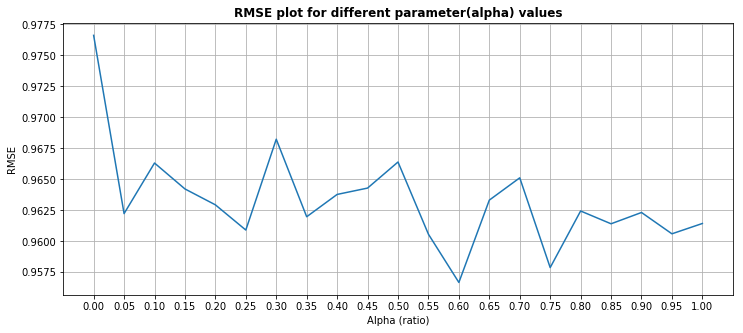

Results:-  Alpha:  0.6    Train RMSE:  0.9567    Test RMSE:  0.9393
---------------------------------------------------------------------
Eigen energy:  0.89984
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


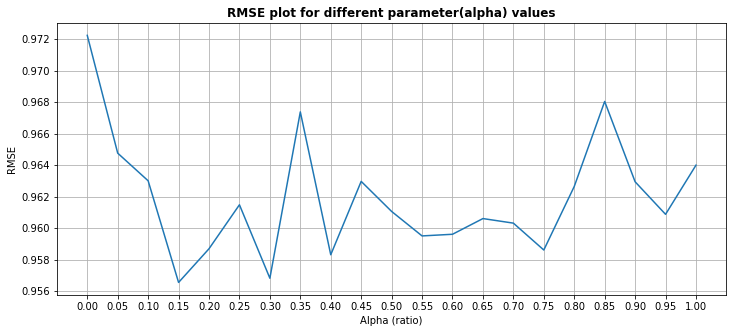

Results:-  Alpha:  0.15    Train RMSE:  0.9566    Test RMSE:  0.9339
---------------------------------------------------------------------
Eigen energy:  0.94727
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


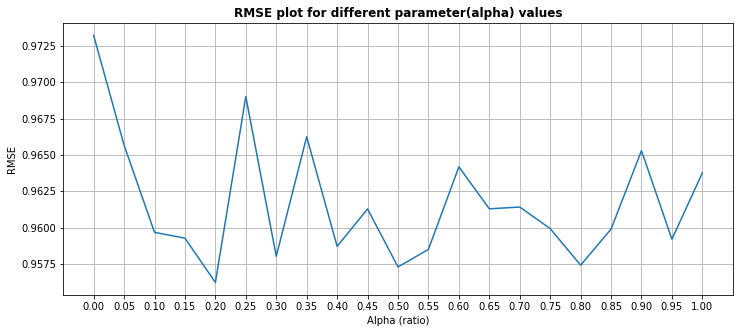

Results:-  Alpha:  0.2    Train RMSE:  0.9562    Test RMSE:  0.9403
---------------------------------------------------------------------
Eigen energy:  0.98962
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


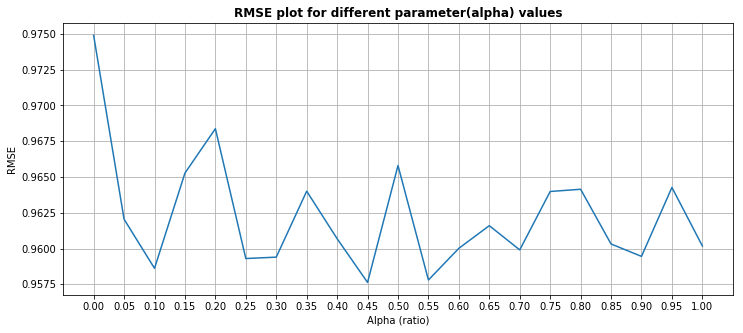

Results:-  Alpha:  0.45    Train RMSE:  0.9576    Test RMSE:  0.9387
---------------------------------------------------------------------


In [23]:
train_rmse_list, test_rmse_list, alpha_list, f1_dim_list, threshold_var_list = get_test_data_pca(variance_ratios, \
                                                                                           evecs_all, \
                                                                                           f_tf_idf_vecs, \
                                                                                           f2_sim_mat, \
                                                                                           mapping, \
                                                                                           train_dict, \
                                                                                           test_dict, comb)

In [24]:
get_table_per_feature_comb(threshold_var_list, f1_dim_list, f2_dim, alpha_list, train_rmse_list, test_rmse_list)

+-------+----------------+--------+--------+-------+------------+-----------+
| Index | Variance ratio | F1 dim | F2 dim | alpha | Train RMSE | Test RMSE |
+-------+----------------+--------+--------+-------+------------+-----------+
|   1   |      0.5       |   2    | 22180  |  0.4  |   0.9575   |   0.9472  |
|   2   |      0.55      |   2    | 22180  |  0.55 |   0.9619   |   0.9482  |
|   3   |      0.6       |   3    | 22180  |  0.45 |   0.9578   |   0.9387  |
|   4   |      0.65      |   4    | 22180  |  0.7  |   0.9583   |   0.9405  |
|   5   |      0.7       |   5    | 22180  |  0.4  |   0.9559   |   0.9241  |
|   6   |      0.75      |   6    | 22180  |  0.4  |   0.9574   |   0.9365  |
|   7   |      0.8       |   9    | 22180  |  0.6  |   0.9546   |   0.9322  |
|   8   |      0.85      |   13   | 22180  |  0.6  |   0.9567   |   0.9393  |
|   9   |      0.9       |   21   | 22180  |  0.15 |   0.9566   |   0.9339  |
|   10  |      0.95      |   31   | 22180  |  0.2  |   0.9562   

In [25]:
index = test_rmse_list.index(min(test_rmse_list))
res1 = [threshold_var_list[index], f1_dim_list[index], alpha_list[index], test_rmse_list[index]]

with open("Results\\res_"+str(comb), 'wb') as bpt:
        pickle.dump(res1, bpt)

<h3> For F1 feature combination: countries, genres</h3>

In [26]:
comb = 9

In [27]:
f_tf_idf_vecs = pickle.load(open('Vec_space_without_pca\\f1_' + str(comb) + '_tf_idf_vecs', 'rb'))

In [28]:
evecs_all, variance_ratios = get_pca(f_tf_idf_vecs)

Eigen energy:  0.46606
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


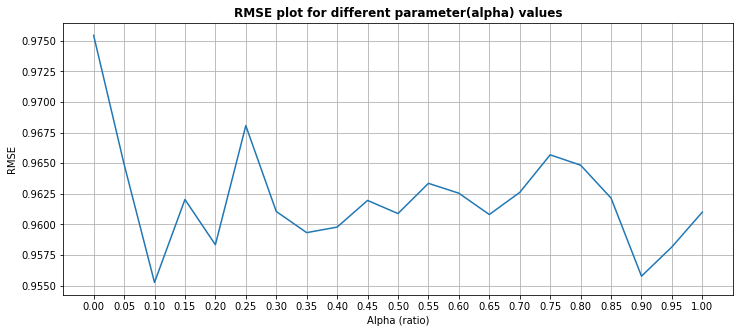

Results:-  Alpha:  0.1    Train RMSE:  0.9553    Test RMSE:  0.9411
---------------------------------------------------------------------
Eigen energy:  0.53436
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


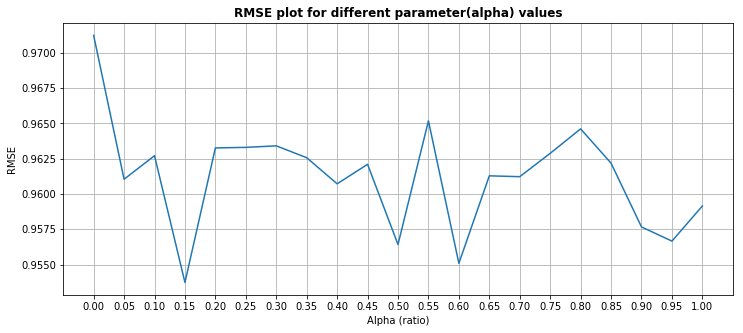

Results:-  Alpha:  0.15    Train RMSE:  0.9537    Test RMSE:  0.9491
---------------------------------------------------------------------
Eigen energy:  0.59379
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


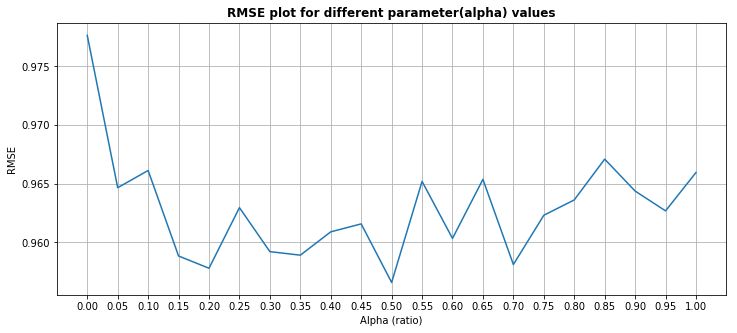

Results:-  Alpha:  0.5    Train RMSE:  0.9566    Test RMSE:  0.9453
---------------------------------------------------------------------
Eigen energy:  0.64445
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


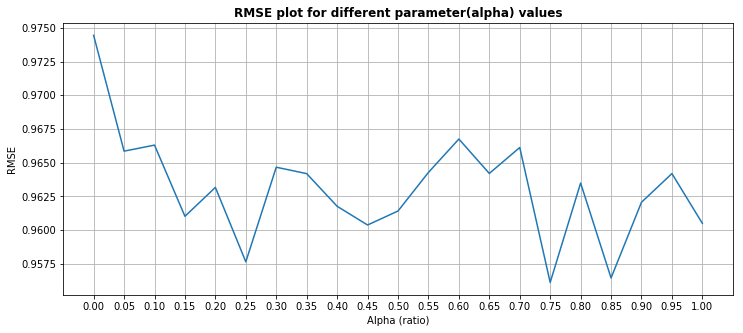

Results:-  Alpha:  0.75    Train RMSE:  0.9561    Test RMSE:  0.9452
---------------------------------------------------------------------
Eigen energy:  0.68937
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


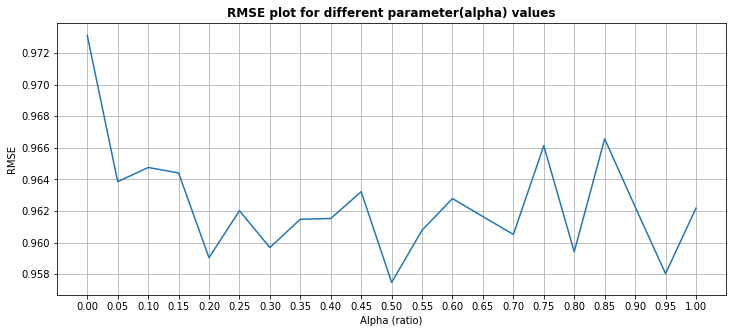

Results:-  Alpha:  0.5    Train RMSE:  0.9575    Test RMSE:  0.9449
---------------------------------------------------------------------
Eigen energy:  0.73089
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


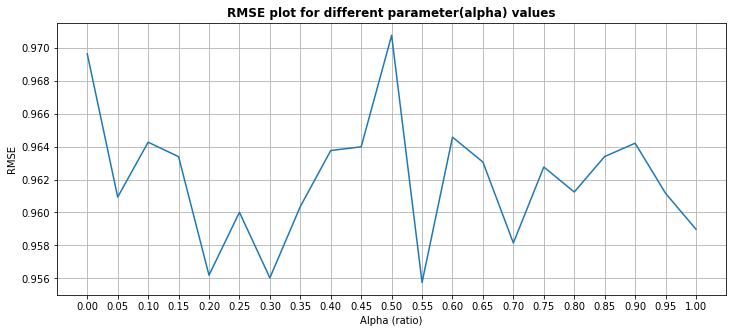

Results:-  Alpha:  0.55    Train RMSE:  0.9558    Test RMSE:  0.9452
---------------------------------------------------------------------
Eigen energy:  0.79843
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


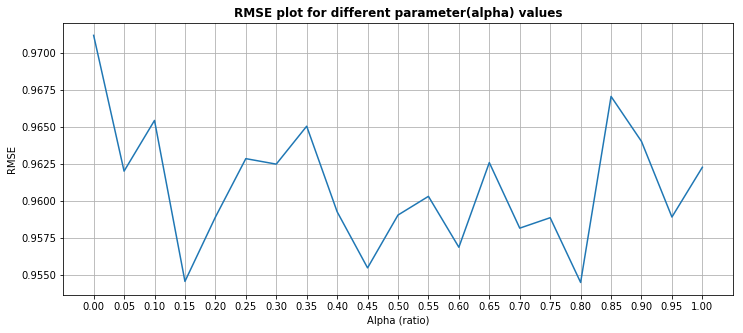

Results:-  Alpha:  0.8    Train RMSE:  0.9545    Test RMSE:  0.9457
---------------------------------------------------------------------
Eigen energy:  0.84918
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


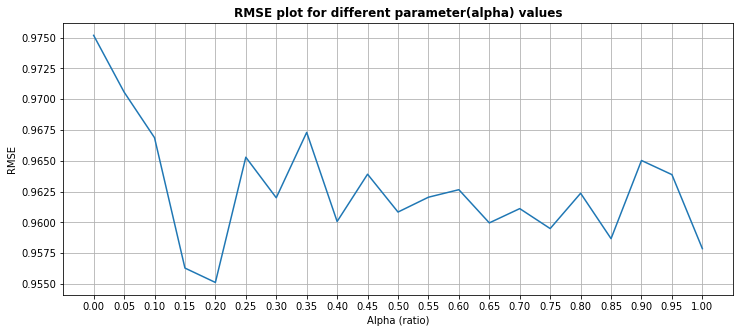

Results:-  Alpha:  0.2    Train RMSE:  0.9551    Test RMSE:  0.9459
---------------------------------------------------------------------
Eigen energy:  0.89753
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


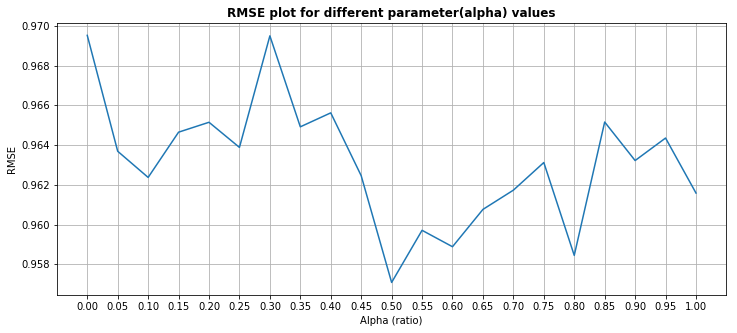

Results:-  Alpha:  0.5    Train RMSE:  0.9571    Test RMSE:  0.9435
---------------------------------------------------------------------
Eigen energy:  0.94683
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


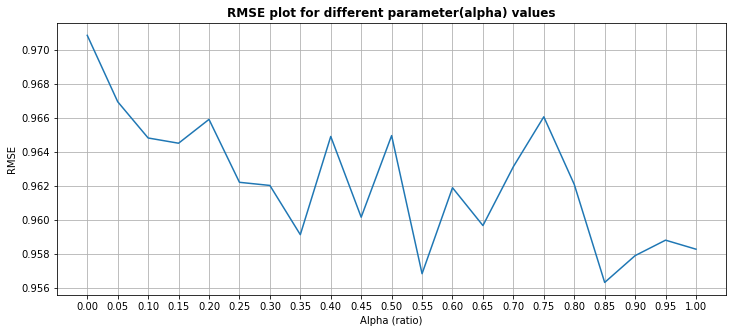

Results:-  Alpha:  0.85    Train RMSE:  0.9563    Test RMSE:  0.9447
---------------------------------------------------------------------
Eigen energy:  0.98974
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


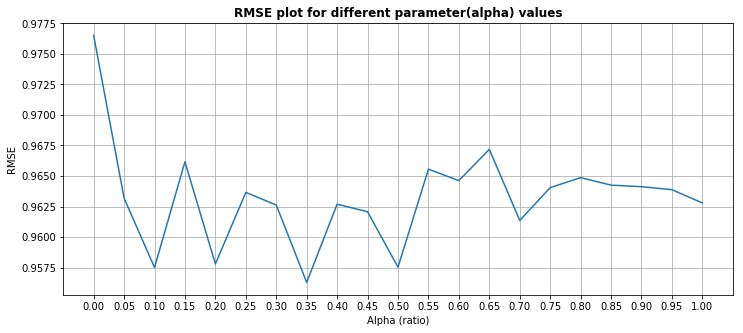

Results:-  Alpha:  0.35    Train RMSE:  0.9563    Test RMSE:  0.9345
---------------------------------------------------------------------


In [29]:
train_rmse_list, test_rmse_list, alpha_list, f1_dim_list, threshold_var_list = get_test_data_pca(variance_ratios, \
                                                                                           evecs_all, \
                                                                                           f_tf_idf_vecs, \
                                                                                           f2_sim_mat, \
                                                                                           mapping, \
                                                                                           train_dict, \
                                                                                           test_dict, comb)

In [30]:
get_table_per_feature_comb(threshold_var_list, f1_dim_list, f2_dim, alpha_list, train_rmse_list, test_rmse_list)

+-------+----------------+--------+--------+-------+------------+-----------+
| Index | Variance ratio | F1 dim | F2 dim | alpha | Train RMSE | Test RMSE |
+-------+----------------+--------+--------+-------+------------+-----------+
|   1   |      0.5       |   8    | 22180  |  0.1  |   0.9553   |   0.9411  |
|   2   |      0.55      |   10   | 22180  |  0.15 |   0.9537   |   0.9491  |
|   3   |      0.6       |   12   | 22180  |  0.5  |   0.9566   |   0.9453  |
|   4   |      0.65      |   14   | 22180  |  0.75 |   0.9561   |   0.9452  |
|   5   |      0.7       |   16   | 22180  |  0.5  |   0.9575   |   0.9449  |
|   6   |      0.75      |   18   | 22180  |  0.55 |   0.9558   |   0.9452  |
|   7   |      0.8       |   22   | 22180  |  0.8  |   0.9545   |   0.9457  |
|   8   |      0.85      |   26   | 22180  |  0.2  |   0.9551   |   0.9459  |
|   9   |      0.9       |   32   | 22180  |  0.5  |   0.9571   |   0.9435  |
|   10  |      0.95      |   44   | 22180  |  0.85 |   0.9563   

In [31]:
index = test_rmse_list.index(min(test_rmse_list))
res1 = [threshold_var_list[index], f1_dim_list[index], alpha_list[index], test_rmse_list[index]]

with open("Results\\res_"+str(comb), 'wb') as bpt:
        pickle.dump(res1, bpt)

<h3> For F1 feature combination:  countries, genres, actors</h3>

In [32]:
comb = 10

In [33]:
f_tf_idf_vecs = pickle.load(open('Vec_space_without_pca\\f1_' + str(comb) + '_tf_idf_vecs', 'rb'))

In [34]:
evecs_all, variance_ratios = get_pca(f_tf_idf_vecs)

Eigen energy:  0.49988
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


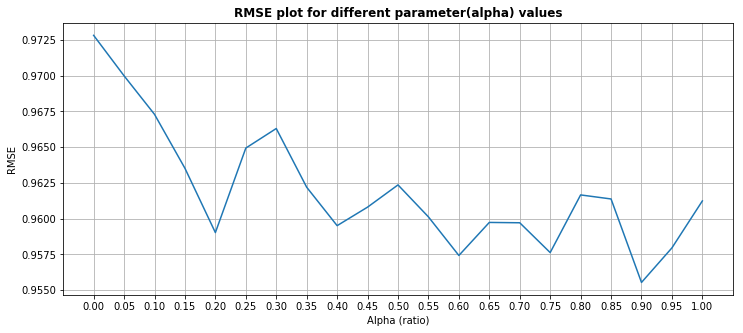

Results:-  Alpha:  0.9    Train RMSE:  0.9555    Test RMSE:  0.9384
---------------------------------------------------------------------
Eigen energy:  0.54985
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


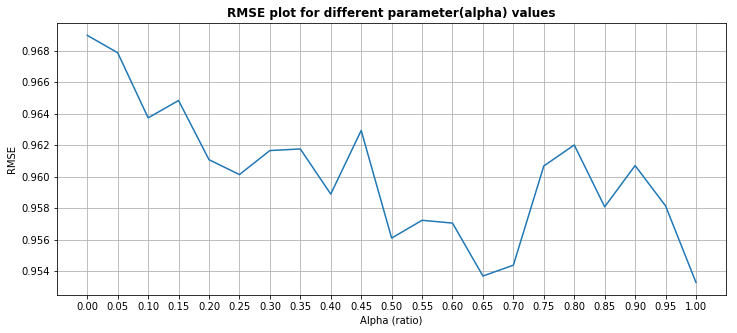

Results:-  Alpha:  1.0    Train RMSE:  0.9533    Test RMSE:  0.9406
---------------------------------------------------------------------
Eigen energy:  0.59991
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


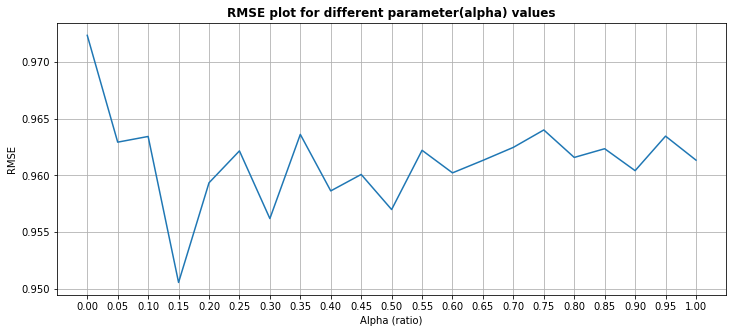

Results:-  Alpha:  0.15    Train RMSE:  0.9506    Test RMSE:  0.9338
---------------------------------------------------------------------
Eigen energy:  0.64983
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


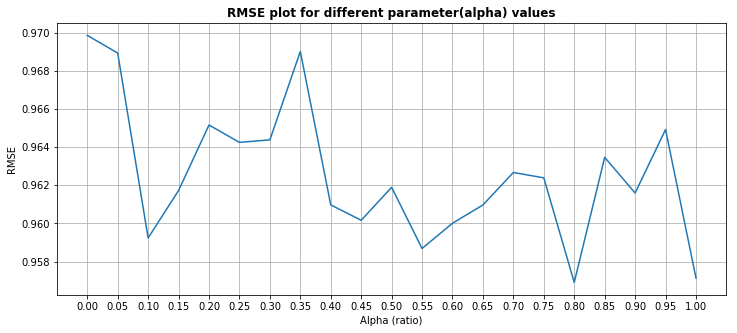

Results:-  Alpha:  0.8    Train RMSE:  0.9569    Test RMSE:  0.9493
---------------------------------------------------------------------
Eigen energy:  0.69995
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


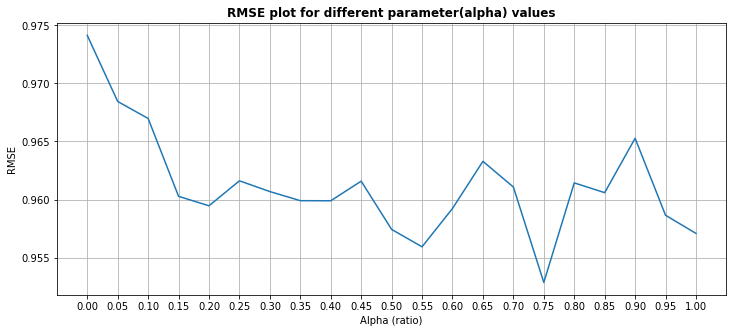

Results:-  Alpha:  0.75    Train RMSE:  0.9529    Test RMSE:  0.9392
---------------------------------------------------------------------
Eigen energy:  0.74985
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


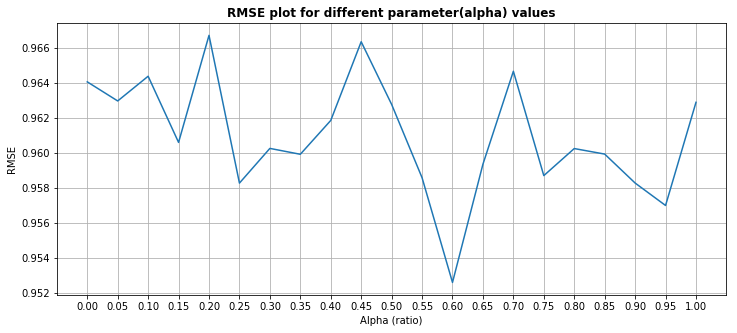

Results:-  Alpha:  0.6    Train RMSE:  0.9526    Test RMSE:  0.9411
---------------------------------------------------------------------
Eigen energy:  0.79999
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


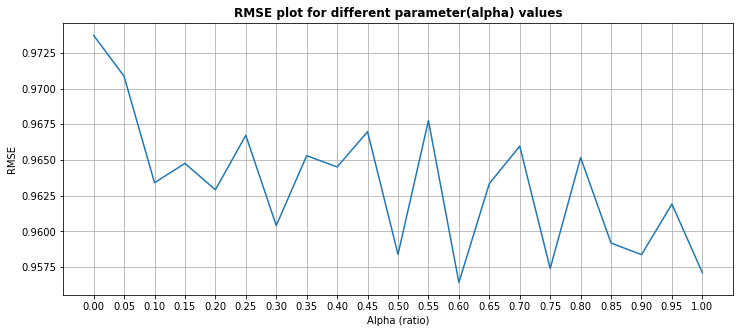

Results:-  Alpha:  0.6    Train RMSE:  0.9564    Test RMSE:  0.9444
---------------------------------------------------------------------
Eigen energy:  0.85000
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


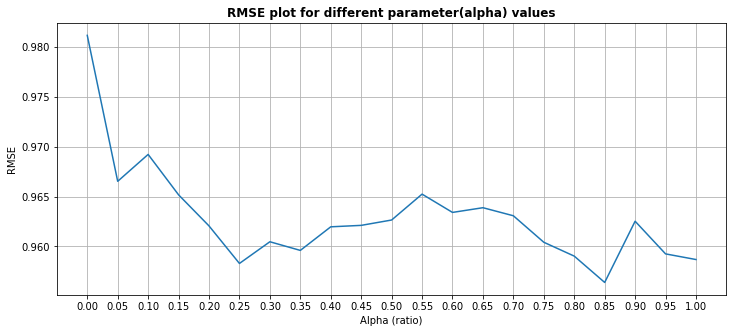

Results:-  Alpha:  0.85    Train RMSE:  0.9564    Test RMSE:  0.9404
---------------------------------------------------------------------
Eigen energy:  0.89992
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


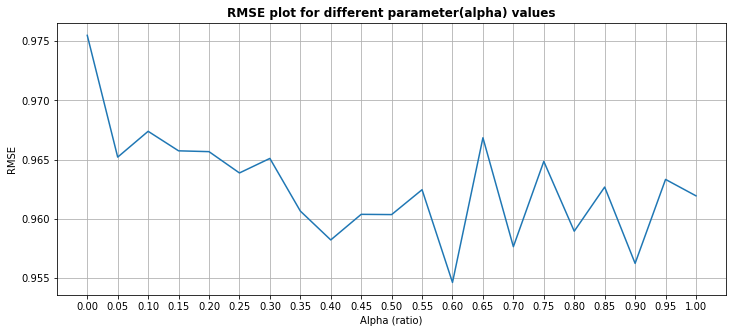

Results:-  Alpha:  0.6    Train RMSE:  0.9546    Test RMSE:  0.9308
---------------------------------------------------------------------
Eigen energy:  0.94994
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


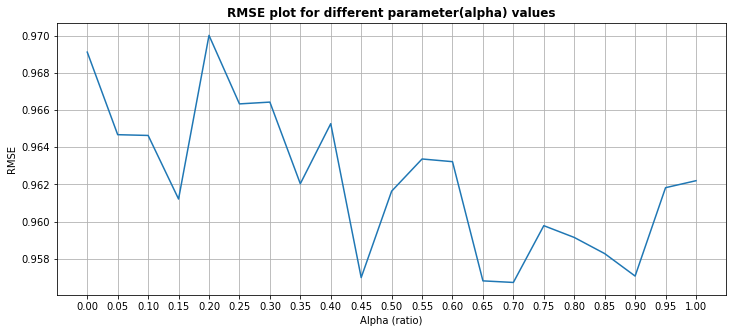

Results:-  Alpha:  0.7    Train RMSE:  0.9567    Test RMSE:  0.9334
---------------------------------------------------------------------
Eigen energy:  0.98996
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


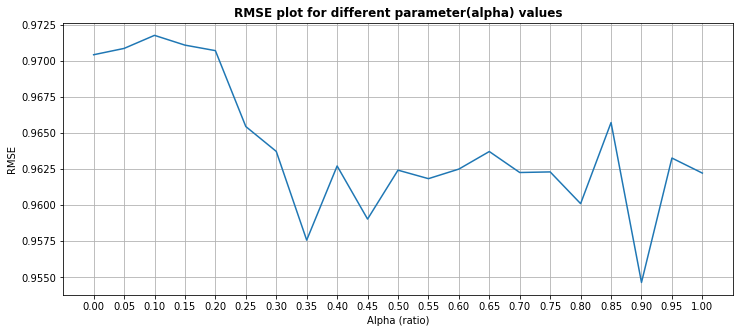

Results:-  Alpha:  0.9    Train RMSE:  0.9546    Test RMSE:  0.9522
---------------------------------------------------------------------


In [35]:
train_rmse_list, test_rmse_list, alpha_list, f1_dim_list, threshold_var_list = get_test_data_pca(variance_ratios, \
                                                                                           evecs_all, \
                                                                                           f_tf_idf_vecs, \
                                                                                           f2_sim_mat, \
                                                                                           mapping, \
                                                                                           train_dict, \
                                                                                           test_dict, comb)

In [36]:
get_table_per_feature_comb(threshold_var_list, f1_dim_list, f2_dim, alpha_list, train_rmse_list, test_rmse_list)

+-------+----------------+--------+--------+-------+------------+-----------+
| Index | Variance ratio | F1 dim | F2 dim | alpha | Train RMSE | Test RMSE |
+-------+----------------+--------+--------+-------+------------+-----------+
|   1   |      0.5       |  1305  | 22180  |  0.9  |   0.9555   |   0.9384  |
|   2   |      0.55      |  1514  | 22180  |  1.0  |   0.9533   |   0.9406  |
|   3   |      0.6       |  1733  | 22180  |  0.15 |   0.9506   |   0.9338  |
|   4   |      0.65      |  1960  | 22180  |  0.8  |   0.9569   |   0.9493  |
|   5   |      0.7       |  2198  | 22180  |  0.75 |   0.9529   |   0.9392  |
|   6   |      0.75      |  2448  | 22180  |  0.6  |   0.9526   |   0.9411  |
|   7   |      0.8       |  2716  | 22180  |  0.6  |   0.9564   |   0.9444  |
|   8   |      0.85      |  3006  | 22180  |  0.85 |   0.9564   |   0.9404  |
|   9   |      0.9       |  3328  | 22180  |  0.6  |   0.9546   |   0.9308  |
|   10  |      0.95      |  3705  | 22180  |  0.7  |   0.9567   

In [37]:
index = test_rmse_list.index(min(test_rmse_list))
res1 = [threshold_var_list[index], f1_dim_list[index], alpha_list[index], test_rmse_list[index]]

with open("Results\\res_"+str(comb), 'wb') as bpt:
        pickle.dump(res1, bpt)

<h3> For F1 feature combination: countries, genres, actors, directors</h3>

In [38]:
comb = 13

In [39]:
f_tf_idf_vecs = pickle.load(open('Vec_space_without_pca\\f1_' + str(comb) + '_tf_idf_vecs', 'rb'))

In [40]:
evecs_all, variance_ratios = get_pca(f_tf_idf_vecs)

Eigen energy:  0.49995
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


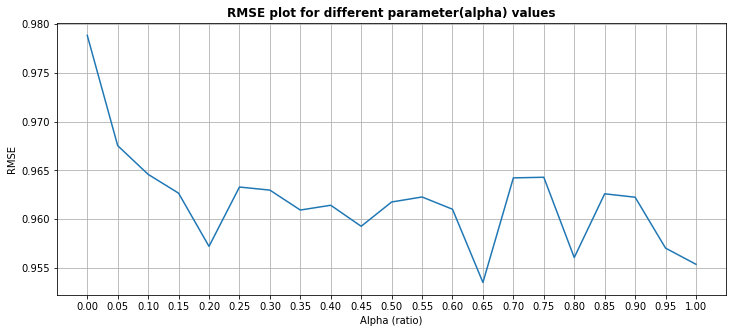

Results:-  Alpha:  0.65    Train RMSE:  0.9535    Test RMSE:  0.9426
---------------------------------------------------------------------
Eigen energy:  0.54992
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


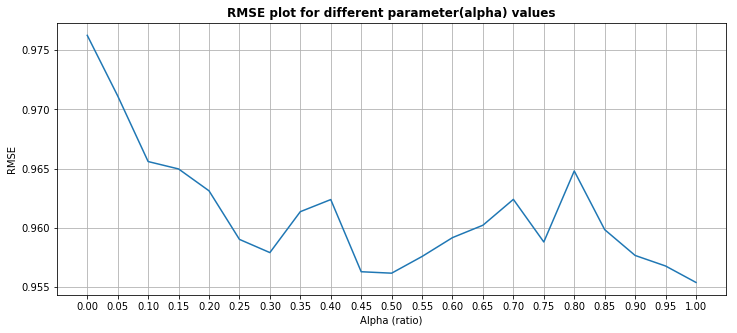

Results:-  Alpha:  1.0    Train RMSE:  0.9554    Test RMSE:  0.9406
---------------------------------------------------------------------
Eigen energy:  0.59981
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


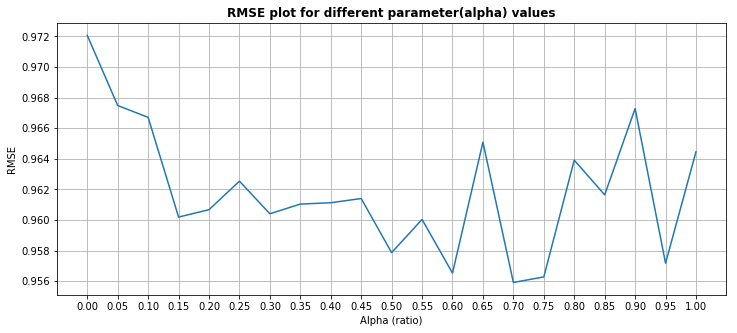

Results:-  Alpha:  0.7    Train RMSE:  0.9559    Test RMSE:  0.928
---------------------------------------------------------------------
Eigen energy:  0.64986
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


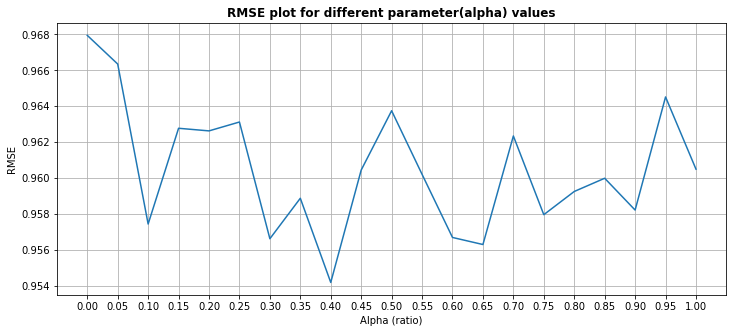

Results:-  Alpha:  0.4    Train RMSE:  0.9542    Test RMSE:  0.9477
---------------------------------------------------------------------
Eigen energy:  0.69980
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


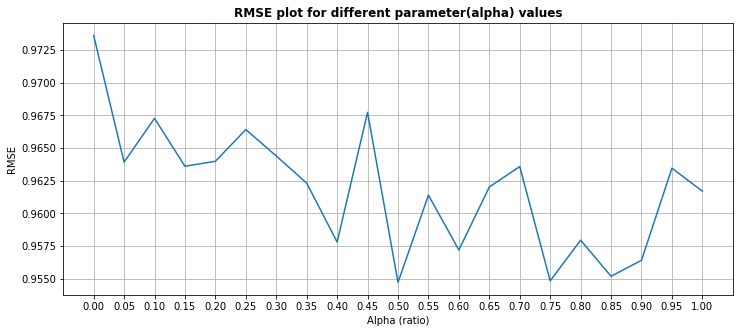

Results:-  Alpha:  0.5    Train RMSE:  0.9547    Test RMSE:  0.9492
---------------------------------------------------------------------
Eigen energy:  0.74987
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


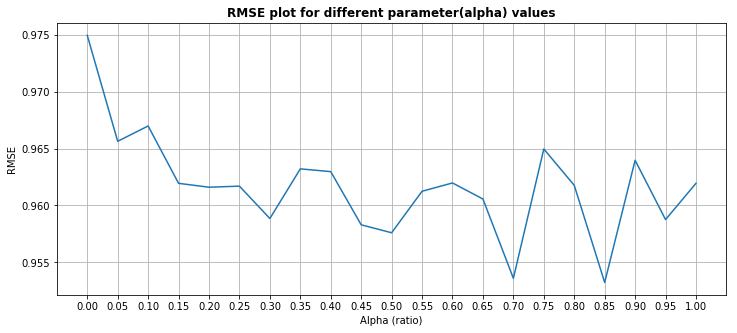

Results:-  Alpha:  0.85    Train RMSE:  0.9532    Test RMSE:  0.9498
---------------------------------------------------------------------
Eigen energy:  0.79997
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


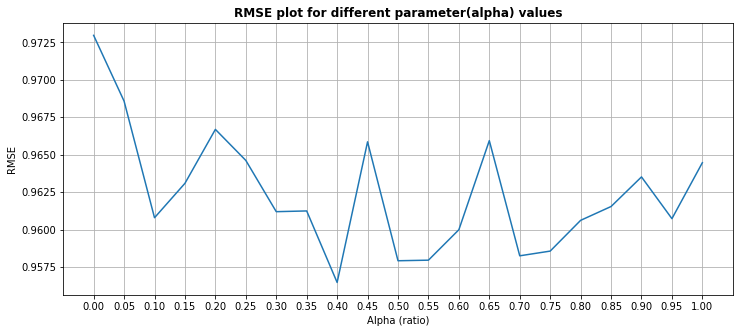

Results:-  Alpha:  0.4    Train RMSE:  0.9565    Test RMSE:  0.9406
---------------------------------------------------------------------
Eigen energy:  0.85000
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


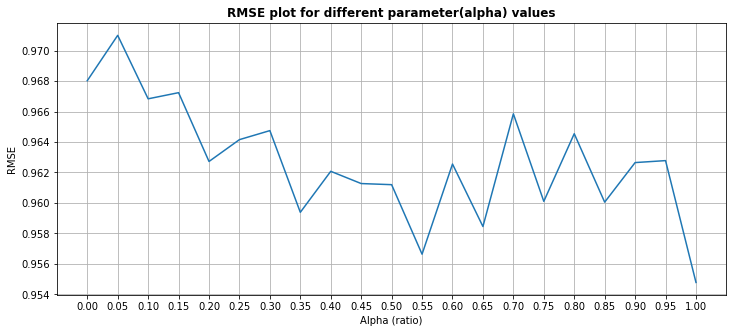

Results:-  Alpha:  1.0    Train RMSE:  0.9548    Test RMSE:  0.9402
---------------------------------------------------------------------
Eigen energy:  0.89986
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


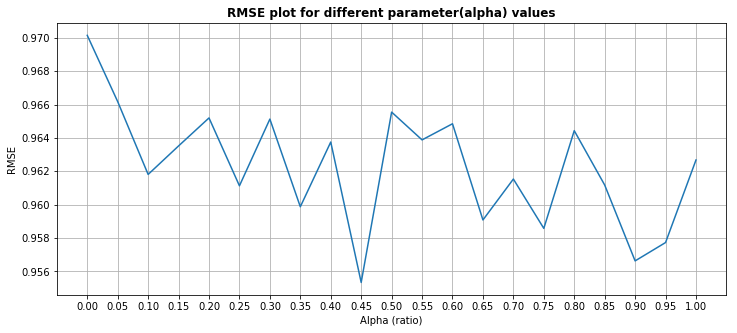

Results:-  Alpha:  0.45    Train RMSE:  0.9553    Test RMSE:  0.9436
---------------------------------------------------------------------
Eigen energy:  0.94992
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


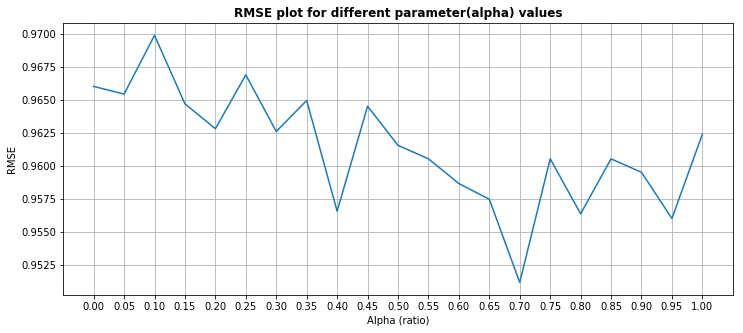

Results:-  Alpha:  0.7    Train RMSE:  0.9512    Test RMSE:  0.9425
---------------------------------------------------------------------
Eigen energy:  0.98999
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


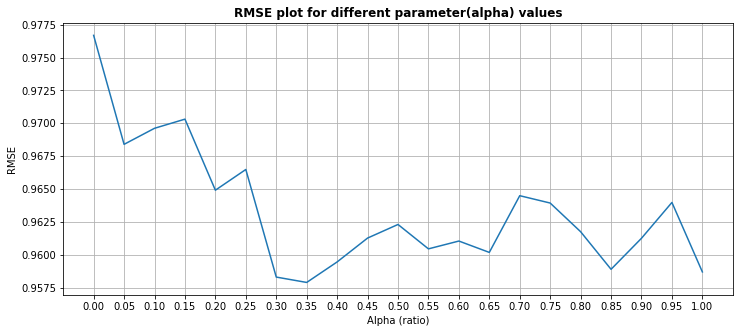

Results:-  Alpha:  0.35    Train RMSE:  0.9579    Test RMSE:  0.9433
---------------------------------------------------------------------


In [41]:
train_rmse_list, test_rmse_list, alpha_list, f1_dim_list, threshold_var_list = get_test_data_pca(variance_ratios, \
                                                                                           evecs_all, \
                                                                                           f_tf_idf_vecs, \
                                                                                           f2_sim_mat, \
                                                                                           mapping, \
                                                                                           train_dict, \
                                                                                           test_dict, comb)

In [42]:
get_table_per_feature_comb(threshold_var_list, f1_dim_list, f2_dim, alpha_list, train_rmse_list, test_rmse_list)

+-------+----------------+--------+--------+-------+------------+-----------+
| Index | Variance ratio | F1 dim | F2 dim | alpha | Train RMSE | Test RMSE |
+-------+----------------+--------+--------+-------+------------+-----------+
|   1   |      0.5       |  1385  | 22180  |  0.65 |   0.9535   |   0.9426  |
|   2   |      0.55      |  1597  | 22180  |  1.0  |   0.9554   |   0.9406  |
|   3   |      0.6       |  1817  | 22180  |  0.7  |   0.9559   |   0.928   |
|   4   |      0.65      |  2046  | 22180  |  0.4  |   0.9542   |   0.9477  |
|   5   |      0.7       |  2285  | 22180  |  0.5  |   0.9547   |   0.9492  |
|   6   |      0.75      |  2538  | 22180  |  0.85 |   0.9532   |   0.9498  |
|   7   |      0.8       |  2808  | 22180  |  0.4  |   0.9565   |   0.9406  |
|   8   |      0.85      |  3100  | 22180  |  1.0  |   0.9548   |   0.9402  |
|   9   |      0.9       |  3422  | 22180  |  0.45 |   0.9553   |   0.9436  |
|   10  |      0.95      |  3794  | 22180  |  0.7  |   0.9512   

In [43]:
index = test_rmse_list.index(min(test_rmse_list))
res1 = [threshold_var_list[index], f1_dim_list[index], alpha_list[index], test_rmse_list[index]]

with open("Results\\res_"+str(comb), 'wb') as bpt:
        pickle.dump(res1, bpt)

<h3> For F1 feature combination: countries, genres, actors, keyterms </h3>

In [44]:
comb = 14

In [45]:
f_tf_idf_vecs = pickle.load(open('Vec_space_without_pca\\f1_' + str(comb) + '_tf_idf_vecs', 'rb'))

In [46]:
evecs_all, variance_ratios = get_pca(f_tf_idf_vecs)

Eigen energy:  0.49989
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


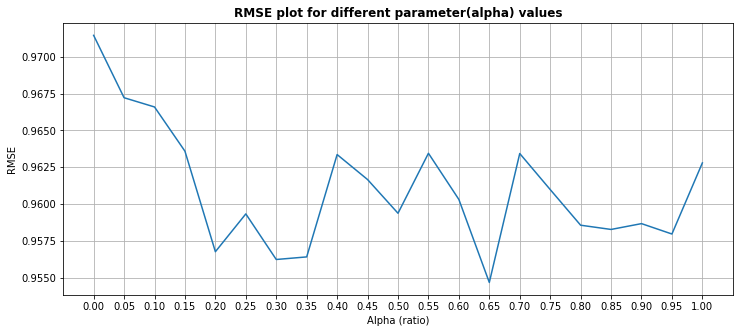

Results:-  Alpha:  0.65    Train RMSE:  0.9547    Test RMSE:  0.9299
---------------------------------------------------------------------
Eigen energy:  0.54999
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


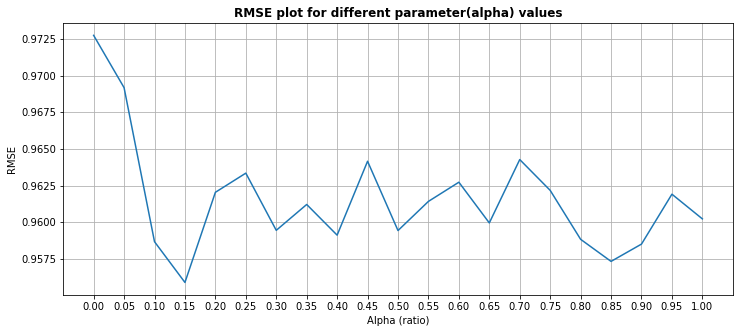

Results:-  Alpha:  0.15    Train RMSE:  0.9559    Test RMSE:  0.9371
---------------------------------------------------------------------
Eigen energy:  0.59983
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


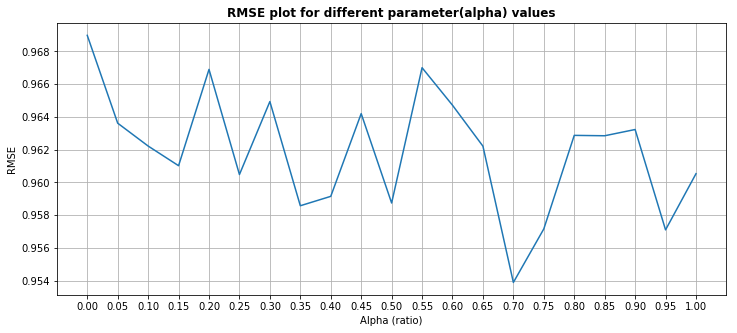

Results:-  Alpha:  0.7    Train RMSE:  0.9539    Test RMSE:  0.9276
---------------------------------------------------------------------
Eigen energy:  0.64997
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


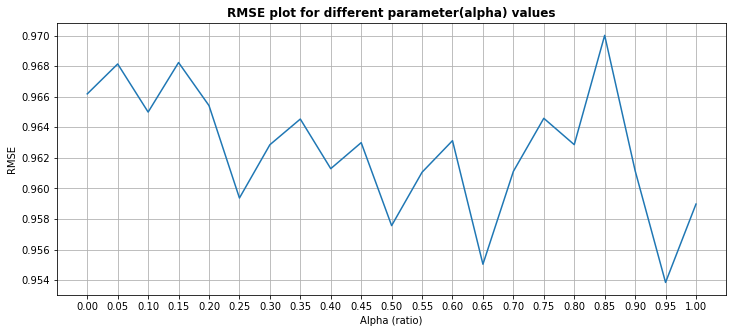

Results:-  Alpha:  0.95    Train RMSE:  0.9539    Test RMSE:  0.9349
---------------------------------------------------------------------
Eigen energy:  0.69989
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


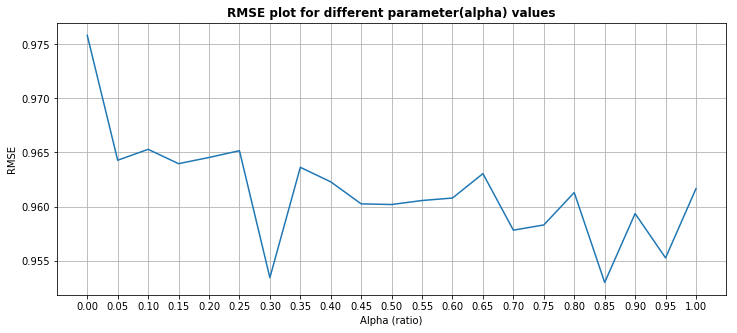

Results:-  Alpha:  0.85    Train RMSE:  0.953    Test RMSE:  0.9333
---------------------------------------------------------------------
Eigen energy:  0.74993
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


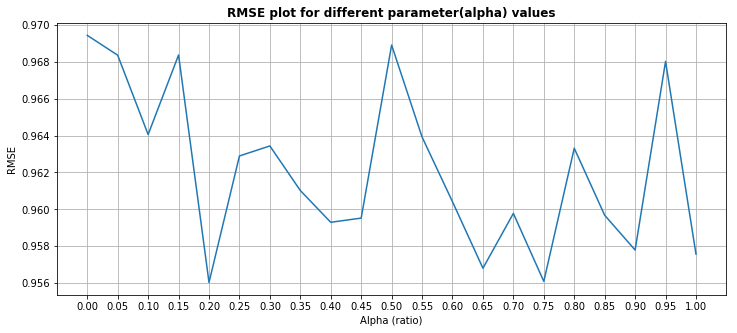

Results:-  Alpha:  0.2    Train RMSE:  0.956    Test RMSE:  0.9382
---------------------------------------------------------------------
Eigen energy:  0.79986
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


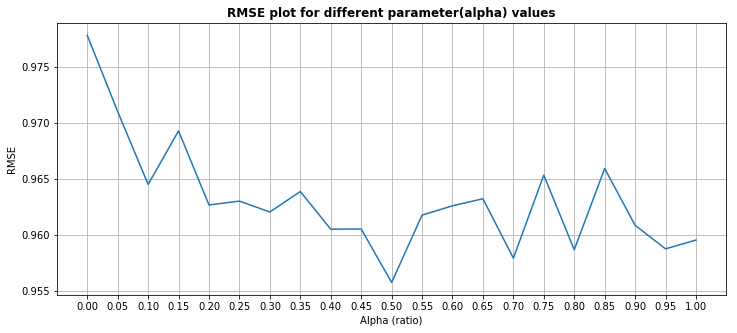

Results:-  Alpha:  0.5    Train RMSE:  0.9558    Test RMSE:  0.9416
---------------------------------------------------------------------
Eigen energy:  0.84987
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


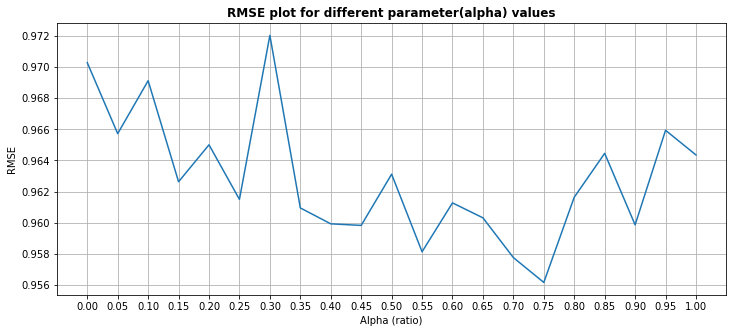

Results:-  Alpha:  0.75    Train RMSE:  0.9562    Test RMSE:  0.948
---------------------------------------------------------------------
Eigen energy:  0.89988
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


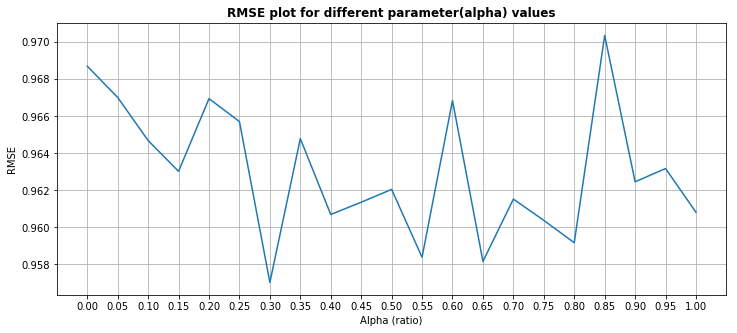

Results:-  Alpha:  0.3    Train RMSE:  0.957    Test RMSE:  0.958
---------------------------------------------------------------------
Eigen energy:  0.94992
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


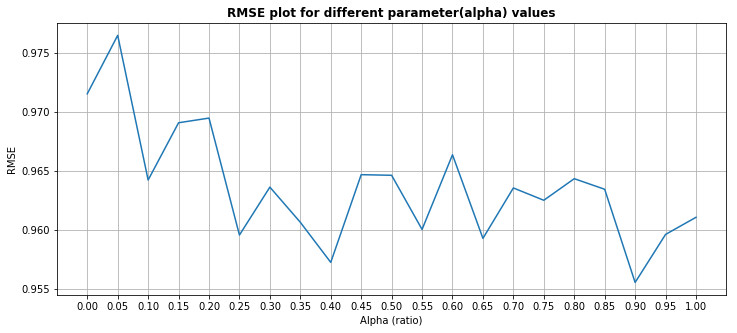

Results:-  Alpha:  0.9    Train RMSE:  0.9556    Test RMSE:  0.9405
---------------------------------------------------------------------
Eigen energy:  0.98996
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


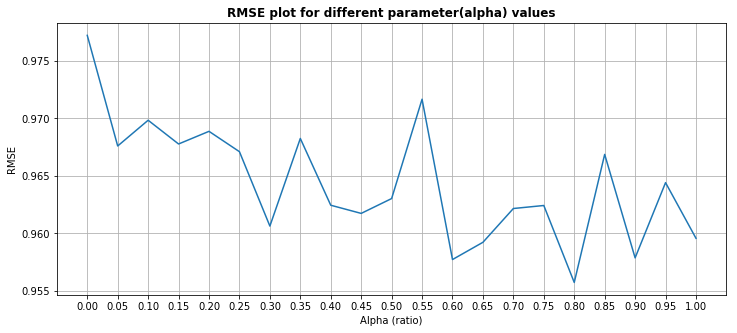

Results:-  Alpha:  0.8    Train RMSE:  0.9557    Test RMSE:  0.9497
---------------------------------------------------------------------


In [47]:
train_rmse_list, test_rmse_list, alpha_list, f1_dim_list, threshold_var_list = get_test_data_pca(variance_ratios, \
                                                                                           evecs_all, \
                                                                                           f_tf_idf_vecs, \
                                                                                           f2_sim_mat, \
                                                                                           mapping, \
                                                                                           train_dict, \
                                                                                           test_dict, comb)

In [48]:
get_table_per_feature_comb(threshold_var_list, f1_dim_list, f2_dim, alpha_list, train_rmse_list, test_rmse_list)

+-------+----------------+--------+--------+-------+------------+-----------+
| Index | Variance ratio | F1 dim | F2 dim | alpha | Train RMSE | Test RMSE |
+-------+----------------+--------+--------+-------+------------+-----------+
|   1   |      0.5       |  1198  | 22180  |  0.65 |   0.9547   |   0.9299  |
|   2   |      0.55      |  1405  | 22180  |  0.15 |   0.9559   |   0.9371  |
|   3   |      0.6       |  1623  | 22180  |  0.7  |   0.9539   |   0.9276  |
|   4   |      0.65      |  1854  | 22180  |  0.95 |   0.9539   |   0.9349  |
|   5   |      0.7       |  2098  | 22180  |  0.85 |   0.953    |   0.9333  |
|   6   |      0.75      |  2360  | 22180  |  0.2  |   0.956    |   0.9382  |
|   7   |      0.8       |  2643  | 22180  |  0.5  |   0.9558   |   0.9416  |
|   8   |      0.85      |  2954  | 22180  |  0.75 |   0.9562   |   0.948   |
|   9   |      0.9       |  3303  | 22180  |  0.3  |   0.957    |   0.958   |
|   10  |      0.95      |  3712  | 22180  |  0.9  |   0.9556   

In [49]:
index = test_rmse_list.index(min(test_rmse_list))
res1 = [threshold_var_list[index], f1_dim_list[index], alpha_list[index], test_rmse_list[index]]

with open("Results\\res_"+str(comb), 'wb') as bpt:
        pickle.dump(res1, bpt)

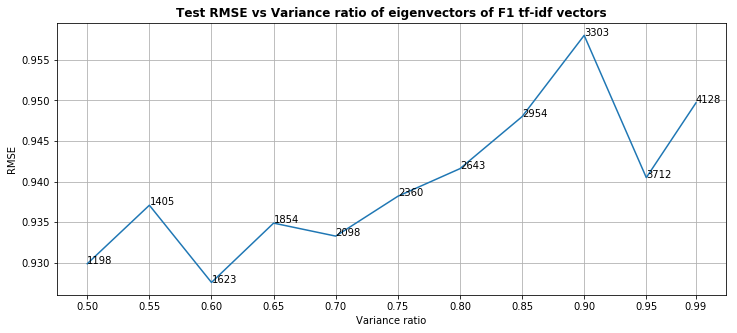

In [53]:
get_plot(threshold_var_list, test_rmse_list, axis_names=['Variance ratio','RMSE'], title = 'Test RMSE vs Variance ratio of eigenvectors of F1 tf-idf vectors', dim_list = f1_dim_list)